In [1]:
import numpy as np
import pandas as pd

In [2]:
dataframe = pd.read_csv('household_power_consumption.txt', delimiter=';', infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
dataframe.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [4]:
# fill missing values with a value at the same time one day ago
def fill_missing(values):
    one_day = 60 * 24
    for row in range(values.shape[0]):
        for col in range(values.shape[1]):
            if np.isnan(values[row, col]):
                values[row, col] = values[row - one_day, col]
 
# mark all missing values
dataframe.replace('?', np.nan , inplace=True)
# make dataset numeric
dataframe = dataframe.astype('float32')
# fill missing
fill_missing(dataframe.values)

In [5]:
df = dataframe['Global_active_power']
df.head()

datetime
2006-12-16 17:24:00    4.216
2006-12-16 17:25:00    5.360
2006-12-16 17:26:00    5.374
2006-12-16 17:27:00    5.388
2006-12-16 17:28:00    3.666
Name: Global_active_power, dtype: float32

In [6]:
from sklearn.model_selection import train_test_split
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

steps = 60
X, y = split_sequence(df.to_numpy(), n_steps=steps)
print(np.shape(X),np.shape(y))
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state = 42)

(2075199, 60) (2075199,)


In [16]:
class LinearRegression:

    def fit(self, X, y, lr = 0.001, iters=1000, verbose=True, batch_size=1):
        X = self.add_bias(X)
        self.weights = np.zeros(len(X[0]))
        for i in range(iters):
            idx = np.random.choice(len(X), batch_size) 
            X_batch, y_batch =  X[idx], y[idx]
            self.weights -= lr * self.get_gradient(X_batch, y_batch)
            if i % 1000 == 0 and verbose: 
                print('Iterations: %d - Error : %.4f' %(i, self.get_loss(X,y)))
                
    def predict(self, X):
        return self.predict_(self.add_bias(X))
    
    def get_loss(self, X, y):
        return np.mean((y - self.predict_(X)) ** 2)
    
    def predict_(self, X):
        return np.dot(X,self.weights)
    
    def add_bias(self,X):
        return np.insert(X, 0, np.ones(len(X)), axis=1)
        
    def get_gradient(self, X, y):
        return -1.0 * np.dot(y - self.predict_(X), X) / len(X)
    
    def evaluate(self, X, y):
        return self.get_loss(self.add_bias(X), y)

In [31]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train, iters = 11000)

Iterations: 0 - Error : 2.2783
Iterations: 1000 - Error : 0.1467
Iterations: 2000 - Error : 0.1214
Iterations: 3000 - Error : 0.1194
Iterations: 4000 - Error : 0.0968
Iterations: 5000 - Error : 0.0932
Iterations: 6000 - Error : 0.0942
Iterations: 7000 - Error : 0.0920
Iterations: 8000 - Error : 0.0849
Iterations: 9000 - Error : 0.0830
Iterations: 10000 - Error : 0.0846


Mean squared error: 0.08
Variance score: 0.93
(415040, 60) (415040,)


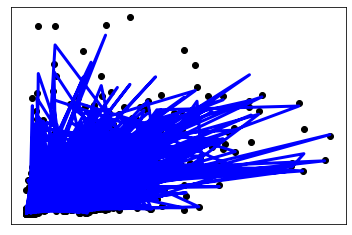

In [32]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

y_pred = lin_reg.predict(X_test)
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_pred))

# Plot outputs
print(X_test.shape, y_test.shape)
plt.scatter(X_test[:1000,0], y_test[:1000],  color='black')
plt.plot(X_test[:1000,0], y_pred[:1000], color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()